<a href="https://colab.research.google.com/github/mpustil/DoctoradoPustilnik/blob/main/Swift_AED2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# graficos color magnitud
# carga con imputacion y submuestreo  (1/12/2025)


import pandas as pd
import numpy as np
import gc

'''
Archivos utilizados
Swift05_11SBS165.csv
https://drive.google.com/file/d/1T53fIqyrr70CHqXvB5lp0deJTxrfHUfV/view?usp=sharing
Swift05_11SBS52.csv
https://drive.google.com/file/d/1dQ5puACEkvwEE3zOl1vIrPglVQHXO7gD/view?usp=sharing

Swift11NoSBS.csv (solo registros sin flags de error)
https://drive.google.com/file/d/1-kSWbAy4ZL73eb6Wik3cei1s4iA1H1-j/view?usp=drive_link

'''
# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4']
  df[cols] = df[cols].applymap(np.int64)
  #variable target
  df['52'] = clase

  df.drop(['2', '112', '113', '114', '115'], axis=1, inplace=True)
  if clase == 1:
    #df.drop(['50','51','53'], axis=1, inplace=True)
    #Nos quedamos con el nombre
    df.drop(['50','51'], axis=1, inplace=True)
  else:
    df['53'] = ''

  # ponemos los NA
  listaVariables = ['110','111']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)

  #que tenga al menos uno de los filtros
  df = df[(df['110'] >= 0) | (df['111'] >=0 ) ]
  if clase == 0:
  #que no tenga flags
     df = df[(df['20'] == 0) & (df['21'] ==0 ) ]
     df.drop(['20','21'], axis=1, inplace=True)

  return df



#-------------------------------------------------------------imputacion lineal (en datos sin resumir)
from sklearn.linear_model import LinearRegression
import math

#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

#Imputacion por regresion lineal
def regresionLineal(df):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  #print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  #print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  #print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")

  #print()
  #print(df.corr())
  df['111'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)



#-------------------------- Pre-procesamiento parte 2: submuestreo y sobremuestreo (codigo). ya viene todo imputado!

# importamos librerias para balancear los datos
from imblearn.under_sampling import RandomUnderSampler

#SMOTE (Synthetic Minority Over-sampling Technique)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE

def subMuestrear(df, _random_state):

  # vamos a dejar un 10% de SBS (sampling_strategy = 0.1) y 90% NoSBS, para luego, hacer oversamplig de SBS...
  #undersample = RandomUnderSampler(random_state=_random_state, sampling_strategy = 0.1)

  # vamos a dejar igual peso, 50% de SBS, pporque vamos a repetir esto muchas veces
  undersample = RandomUnderSampler(random_state=_random_state, sampling_strategy = 1)
  #oversample = SMOTE(random_state=random_state)

  # Separamos en X e y
  X_SBS = df.drop(['52'], axis=1)
  y_SBS = df['52']

  #hacemos el submuestreo
  X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)


  # preparamos todo para agrupar despues
  df = X_over_SBS
  df['52'] = y_over_SBS
  dfSBS2 = df[(df['52'] == 1)]
  dfNoSBS2 = df[(df['52'] == 0)]
  dfSBS2.drop(['52'], axis=1,inplace= True)
  dfNoSBS2.drop(['52'], axis=1,inplace= True)

  return dfSBS2, dfNoSBS2

#print(len(dfSBS2), len(dfNoSBS2), len(X_over_SBS), len(df))

# Agrupador prepM3b  (y submuestreo del modelo agrupado)

def desvio0(min, max, desvio)->float:
  ret = float('nan')
  if not math.isnan(min):
    ret = desvio
    if min == max:
      ret = 0.0
  return ret


#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3b(df, clase):

  #2: obsid, 4: fuente   mantenemos la fuente, para poder hacer el ranking
#   df = df.groupby(['4'],group_keys=True).agg(
  df = df.groupby(['4'],group_keys=True).agg(
      #count=('2','count'),  # cant obs

      SBS=('53', 'min'),
      min110=('110', 'min'),
      max110=('110', 'max'),
      mean110=('110', 'mean'),
      std110=('110', 'std'),

      min111=('111', 'min'),
      max111=('111', 'max'),
      mean111=('111', 'mean'),
      std111=('111', 'std'))

  #corregimos el desvio muestral (cuando hay 1 sola muestra)
  df['std110'] = df.apply(lambda x: desvio0(x['min110'],x['max110'],x['std110']), axis=1)
  df['std111'] = df.apply(lambda x: desvio0(x['min111'],x['max111'],x['std111']), axis=1)

  #variable target
  df['52'] = clase

  return df


def prep(_random_state):
  dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')
  dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)

  #imputacion por regresion lineal (en toda la base)
  regresionLineal(dfSBS)
  regresionLineal(dfNoSBS)

  frames = [dfSBS, dfNoSBS]
  df =  pd.concat(frames)

  dfSBS2, dfNoSBS2 = subMuestrear(df, _random_state)

  #agrupamiento
  dfSBS2 = prepM3b(dfSBS2,1)
  dfNoSBS2 = prepM3b(dfNoSBS2,0)

  #print('dfSBS2',len(dfSBS2), 'dfNoSBS2', len(dfNoSBS2))

  frames = [dfSBS2, dfNoSBS2]
  return pd.concat(frames)

# todas (desde el arhivo), imputadas submuestreadas
df = prep(random_state)

df['color'] = df['min110'] -  df['min111']

df['52'] =  np.where(df['52'] == 1, 'SBS', 'NoSBS')

#df['52'] =  np.where(df['color'] > 0, 1, 0)

soloSBS = df[df['52'] == 'SBS'].copy()


/tmp/ipython-input-295465317.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-295465317.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-295465317.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSBS2.drop(['52'], axis=1,inplace= True)
/tmp/ipython-input-295465317.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfNoSBS2.drop(['52'], axis=1,inplace= True)


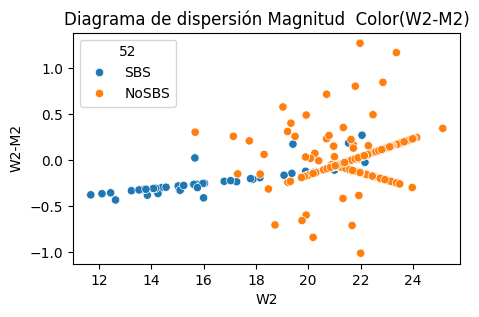

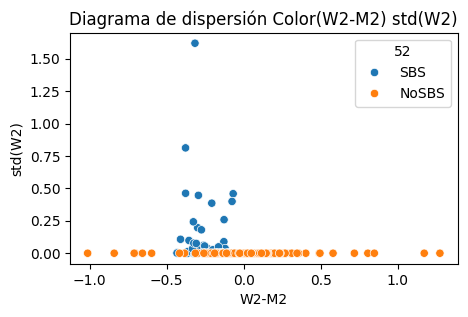

In [ ]:
#Scatter plot de las variables (color)
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd


def diag(df, colX, colY, labelX, labelY, titulo, agNombres):
  #W2 M2
  #sns.scatterplot(x='110', y='111',  data=dfSBS2)
  plt.figure(figsize=(5, 3))
  sns.scatterplot(x=colX, y=colY, hue='52', data=df)

  if agNombres:
    for i, name in enumerate(df['SBS']):
        plt.annotate(name, # The text to display
                    (df[colX].iloc[i], df[colY].iloc[i]), # The point (x, y) to annotate
                    xytext=(5, 5), # Offset the text by a few points
                    textcoords='offset points', # Use offset points for positioning
                    fontsize=9)

  plt.title(titulo)
  plt.xlabel(labelX)
  plt.ylabel(labelY)

  plt.show()


diag(df, 'min110', 'color', 'W2','W2-M2', 'Diagrama de dispersión Magnitud  Color(W2-M2)', False)

diag(df, 'color', 'std110', 'W2-M2','std(W2)', 'Diagrama de dispersión Color(W2-M2) std(W2)', False)


In [ ]:
pip install adjustText

In [ ]:
# marcamos las SBS mal clasificadas

def esta(sbs):
 return sbs in ['M33SyS J013239.11+303836.5', 'M33SyS J013334.95+305108.3', 'OGLE BLG-LPV-26902', 'M31SyS J004335.01+414358.2', \
         'M31SyS J004117.11+404524.1', 'M33SyS J013303.27+303528.3', 'LGGS J004216.72+404415.8']

soloSBS['SBS'] = soloSBS['SBS'].apply(lambda x: x if esta(x)  else 'OK')

#saco desvios atipicos, acorto los nombres
soloSBS2 = soloSBS[soloSBS['std110'] < 0.5].copy()
soloSBS2['SBS'] = soloSBS2['SBS'].apply(lambda x: 'X' if esta(x)  else 'OK')

In [ ]:
soloSBS.head()

,SBS,min110,max110,mean110,std110,min111,max111,mean111,std111,52,color
4,,,,,,,,,,,
119367,M31SyS J004117.11+404524.1,21.002953,21.002953,21.002953,0.000000,21.110900,21.110900,21.110900,0.000000,SBS,-0.107947
124101,OK,21.113800,22.712100,21.547560,0.459413,21.182092,22.711686,21.634304,0.442660,SBS,-0.068292
127860,LGGS J004216.72+404415.8,21.542200,21.542200,21.542200,0.000000,21.355100,21.355100,21.355100,0.000000,SBS,0.187100
133705,OK,19.375400,19.434800,19.405100,0.042002,19.518421,19.575268,19.546844,0.040197,SBS,-0.143021
143510,M31SyS J004335.01+414358.2,22.055300,22.055300,22.055300,0.000000,21.783500,21.783500,21.783500,0.000000,SBS,0.271800


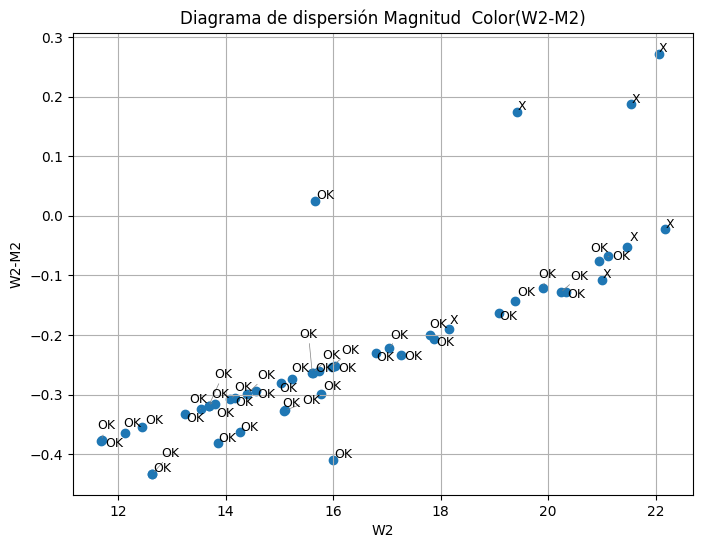

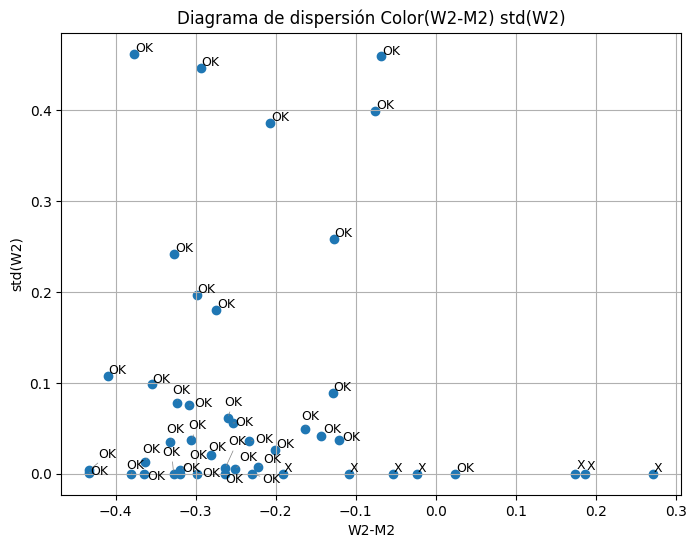

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text

#def diag(df, colX, colY, labelX, labelY, titulo, agNombres):
def diag2(df, colX, colY, labelX, labelY, titulo):

  fig, ax = plt.subplots(figsize=(8, 6))
  ax.scatter(df[colX], df[colY])

  texts = []
  for i, name in enumerate(df['SBS']):
      # Store the text objects in a list
      texts.append(ax.text(df[colX].iloc[i], df[colY].iloc[i], name, fontsize=9))

  # Automatically adjust the text positions to avoid overlap
  adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

  # 4. Add labels and title for clarity (optional)
  plt.xlabel(labelX)
  plt.ylabel(labelY)
  plt.title(titulo)
  plt.grid(True)

  # 5. Display the plot
  plt.show()

diag2(soloSBS,  'min110', 'color', 'W2','W2-M2', 'Diagrama de dispersión Magnitud  Color(W2-M2)')
diag2(soloSBS2, 'color', 'std110', 'W2-M2','std(W2)', 'Diagrama de dispersión Color(W2-M2) std(W2)')


In [ ]:
import pandas as pd
import numpy as np
import gc

# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#preprocesamiento y union de los dataset. Variable target: SBS sii df['52']==1
def prepM3(archivo, clase, archivo2 = ''):
  df = pd.read_csv(archivo, delimiter = ";")

  if archivo2 != '':
    df2 = pd.read_csv(archivo2, delimiter = ";")
    df = pd.concat([df,df2])
    del df2
    gc.collect()


  cols = ['2', '4']
  df[cols] = df[cols].applymap(np.int64)
  #variable target
  df['52'] = clase

  df.drop(['2', '112', '113', '114', '115'], axis=1, inplace=True)
  if clase == 1:
    df.drop(['50','51','53'], axis=1, inplace=True)

  # ponemos los NA
  listaVariables = ['110','111']
  df[listaVariables] = df[listaVariables].replace(0, np.nan)

  #que tenga al menos uno de los filtros
  df = df[(df['110'] >= 0) | (df['111'] >=0 ) ]
  if clase == 0:
  #que no tenga flags
     df = df[(df['20'] == 0) & (df['21'] ==0 ) ]
     df.drop(['20','21'], axis=1, inplace=True)

  return df


dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')
dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)



/tmp/ipython-input-839879760.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)
/tmp/ipython-input-839879760.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(np.int64)


'\nframes = [dfSBS, dfNoSBS]\ndf = pd.concat(frames)\n\n\nprint(len(dfNoSBS),len(dfSBS),len(df))\n'

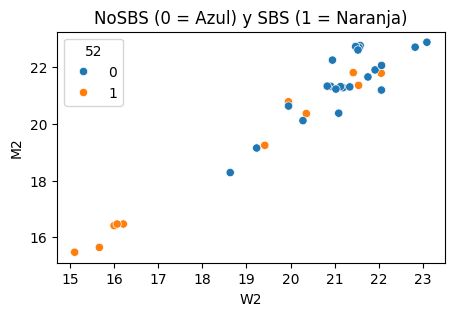

In [ ]:
#Scatter plot de las variables
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd

random_state = 42

#dfSBS = prepM3(ruta + 'Swift05_11SBS165.csv', 1, ruta + 'Swift05_11SBS52.csv')
#dfNoSBS = prepM3(ruta + 'Swift11NoSBS.csv', 0)

#hay 11 SBS en total!
dfSBS2 = dfSBS.dropna()
dfNoSBS2 = dfNoSBS.dropna().sample(22, random_state = random_state)

frames = [dfSBS2, dfNoSBS2]
df = pd.concat(frames)

#data = {'x': [1, 2, 3, 4, 5], 'y': [2, 4, 5, 4, 6], 'category': ['A', 'B', 'A', 'B', 'A']}
#df = pd.DataFrame(data)

#W2 M2
#sns.scatterplot(x='110', y='111',  data=dfSBS2)
plt.figure(figsize=(5, 3))
sns.scatterplot(x='110', y='111', hue='52', data=df)


plt.title("NoSBS (0 = Azul) y SBS (1 = Naranja)")
plt.xlabel('W2')
plt.ylabel('M2')

plt.show()

/tmp/ipython-input-1110343314.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


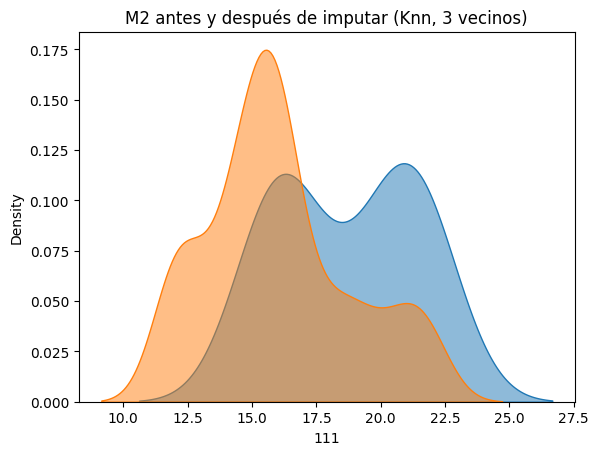

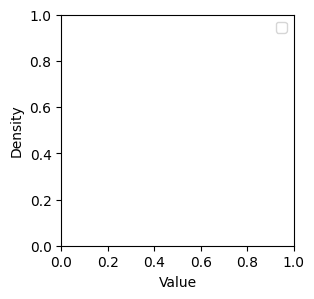

In [ ]:
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def imputar(df, cantVecinos):

      # Identify numerical columns to impute
  numerical_cols = df.select_dtypes(include=np.number).columns
  df_numerical = df[numerical_cols]

  # Initialize and apply KNNImputer  (dejamos los default por ahora)

  imputer = KNNImputer(n_neighbors=cantVecinos, weights = 'distance', metric = 'nan_euclidean')
  imputed_array = imputer.fit_transform(df_numerical)


      # Create a new DataFrame from the imputed array
  df_imputed_numerical = pd.DataFrame(imputed_array, columns=numerical_cols, index=df.index)

  # Identify non-numerical columns
  non_numerical_cols = df.select_dtypes(exclude=np.number).columns

      # Combine imputed numerical columns with original non-numerical columns
  df_rebuilt = pd.concat([df_imputed_numerical, df[non_numerical_cols]], axis=1)

      # Ensure column order if important (optional)
  return df_rebuilt[df.columns]

data1 = dfSBS.dropna()['111']

data2 = imputar(dfSBS.drop(['52'], axis=1),3)['111']

# Plot the density curves
sns.kdeplot(data1, label='M2 antes', fill=True, alpha=0.5)
sns.kdeplot(data2, label='M2 después', fill=True, alpha=0.5)

# Add title and legend
plt.title('M2 antes y después de imputar (Knn, 3 vecinos)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


total con 110 y 111  11
Coefficients: 0.9570129761659465, Intercept: 0.975911747619012
Coefficients: 1.0297437427576632, Intercept: -0.7358644943376085


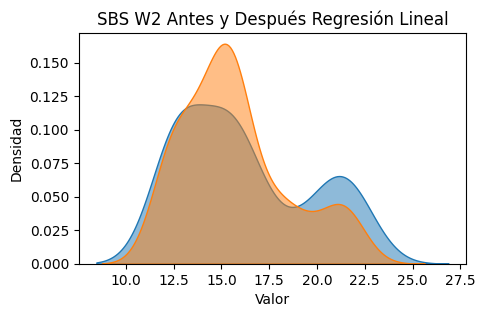

total con 110 y 111  507335
Coefficients: 0.9010081059622165, Intercept: 2.1427737853991644
Coefficients: 0.9246915757012238, Intercept: 1.5309694968660814


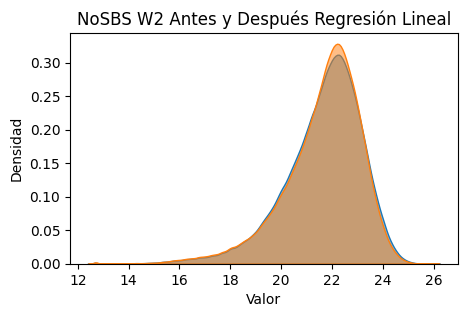

In [ ]:
# Test imputacón lineal
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

def graficarAntesDespuesImputacion(df,titulo):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")


  data1 = df['110']

  #print()
  #print(df.corr())
  df['111i'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110i'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)
  #print(df.corr())


  data2 = df['110i']

  # Create a density plot using seaborn's kdeplot
  plt.figure(figsize=(5, 3))
  #sns.kdeplot([data1, data2], fill=True, color='skyblue', linewidth=2)

  sns.kdeplot(data1, label='W2 antes', fill=True, alpha=0.5)
  sns.kdeplot(data2, label='W2 después', fill=True, alpha=0.5)


  # Add title and labels

  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Densidad')

  # Display the plot
  plt.show()

graficarAntesDespuesImputacion(dfSBS,'SBS W2 Antes y Después Regresión Lineal')
graficarAntesDespuesImputacion(dfNoSBS,'NoSBS W2 Antes y Después Regresión Lineal')

In [ ]:
#imputacion lineal (en datos sin resumir)
from sklearn.linear_model import LinearRegression
import math

#y = ax+b  1 variable por ahora
def imputarLineal(x ,y, a, b):
    if math.isnan(y):
      ret = a*x+b
    else:
      ret = y
    return ret

#Imputacion por regresion lineal
def regresionLineal(df):
  # Dropping the entire rows with missing values
  df_drop = df.dropna()
  #print("total con 110 y 111 ",len(df_drop))
  #print(df_drop)

  # Fitting the linear regression model
  X = df_drop[['110']]
  y = df_drop['111']
  model110 = LinearRegression().fit(X, y)

  X = df_drop[['111']]
  y = df_drop['110']
  model111 = LinearRegression().fit(X, y)

  #print(f"Coefficients: {model110.coef_[0]}, Intercept: {model110.intercept_}")
  #print(f"Coefficients: {model111.coef_[0]}, Intercept: {model111.intercept_}")

  #print()
  #print(df.corr())
  df['111'] = df.apply(lambda x: imputarLineal(x['110'], x['111'], model110.coef_[0], model110.intercept_), axis=1)
  df['110'] = df.apply(lambda x: imputarLineal(x['111'], x['110'], model111.coef_[0], model111.intercept_), axis=1)

#imputacion por regresion lineal (en toda la base)
regresionLineal(dfSBS)
regresionLineal(dfNoSBS)



1890 1890


189 1890


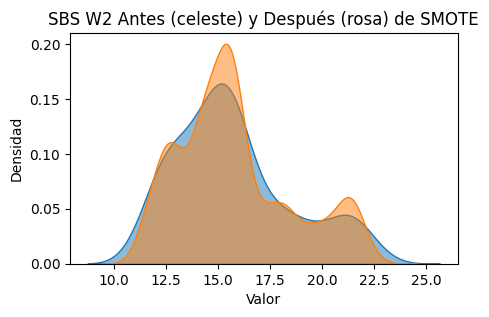

3087686 1890


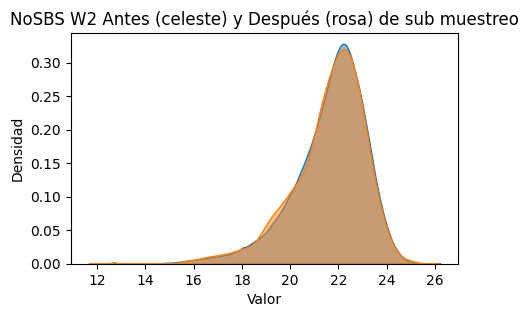

In [ ]:
#antes y despues de SMOTE

# Pre-procesamiento parte 2: submuestreo y sobremuestreo  (ya viene todo imputado!)

# importamos librerias para balancear los datos
from imblearn.under_sampling import RandomUnderSampler

#SMOTE (Synthetic Minority Over-sampling Technique)
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE



# vamos a dejar un 10% de SBS (sampling_strategy = 0.1) y 90% NoSBS, para luego, hacer oversamplig de SBS...
undersample = RandomUnderSampler(random_state=random_state, sampling_strategy = 0.1)

oversample = SMOTE(random_state=random_state)


def graficarAntesDespuesSmote(dfSBS, dfNoSBS,titulo, grupo):

  if grupo == "SBS":
    data1 = dfSBS['110']
  else:
    data1 = dfNoSBS['110']

  frames = [dfSBS, dfNoSBS]
  df = pd.concat(frames)

  # Separamos en X e y
  X_SBS = df.drop(['52'], axis=1)
  y_SBS = df['52']

  #hacemos el submuestreo }
  X_over_SBS, y_over_SBS = undersample.fit_resample(X_SBS , y_SBS)

  # ahora hacemos el oversampling de las SBS
  X_over_SBS, y_over_SBS = oversample.fit_resample(X_over_SBS, y_over_SBS)

  #separamos SBS y NoSBS
  df = X_over_SBS
  df['52'] = y_over_SBS
  dfSBS2 = df[(df['52'] == 1)]
  dfNoSBS2 = df[(df['52'] == 0)]

  if grupo == "SBS":
    data2 = dfSBS2['110']
  else:
    data2 = dfNoSBS2['110']

  print(len(data1), len(data2))

  # Create a density plot using seaborn's kdeplot
  plt.figure(figsize=(5, 3))
  #sns.kdeplot([data1, data2], fill=True, color='skyblue', linewidth=2)


  sns.kdeplot(data1, label='W2 antes', fill=True, alpha=0.5)
  sns.kdeplot(data2, label='W2 después', fill=True, alpha=0.5)

  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Densidad')

  # Display the plot
  plt.show()

graficarAntesDespuesSmote(dfSBS, dfNoSBS, 'SBS W2 Antes (celeste) y Después (rosa) de SMOTE', "SBS")
graficarAntesDespuesSmote(dfSBS, dfNoSBS, 'NoSBS W2 Antes (celeste) y Después (rosa) de sub muestreo', "NoSBS")


In [ ]:
#xxx convendria graficar la distrib de min max


In [ ]:
pip install adjustText


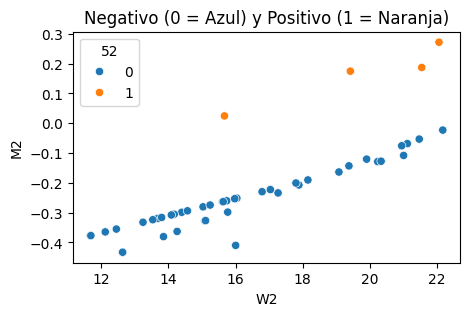

,SBS,min110,max110,mean110,std110,min111,max111,mean111,std111,52,color
0,M31SyS J004117.11+404524.1,21.002953,21.002953,21.002953,0.000000,21.110900,21.110900,21.110900,0.000000,0,-0.107947
1,M31SyS J004155.61+410846.7,21.113800,22.712100,21.547560,0.459413,21.182092,22.711686,21.634304,0.442660,0,-0.068292
2,LGGS J004216.72+404415.8,21.542200,21.542200,21.542200,0.000000,21.355100,21.355100,21.355100,0.000000,1,0.187100
3,NAME SMC Symbiotic star 2,19.375400,19.434800,19.405100,0.042002,19.518421,19.575268,19.546844,0.040197,0,-0.143021
4,M31SyS J004335.01+414358.2,22.055300,22.055300,22.055300,0.000000,21.783500,21.783500,21.783500,0.000000,1,0.271800
5,M33SyS J013239.11+303836.5,21.467500,21.467500,21.467500,0.000000,21.520588,21.520588,21.520588,0.000000,0,-0.053088
6,M33SyS J013303.27+303528.3,18.153755,18.153755,18.153755,0.000000,18.344000,18.344000,18.344000,0.000000,0,-0.190245
7,M33SyS J013334.95+305108.3,19.417100,19.417100,19.417100,0.000000,19.242400,19.242400,19.242400,0.000000,1,0.174700
8,V* AX Per,13.855100,13.855100,13.855100,0.000000,14.235422,14.235422,14.235422,0.000000,0,-0.380322
9,EM* StHA 32,15.611214,15.611214,15.611214,0.000000,15.874900,15.874900,15.874900,0.000000,0,-0.263686


In [ ]:
#scatterplot con nombres y color
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# To obtain a deterministic behaviour during subsampling and fitting, random_state has to be fixed to an integer
random_state = 41

ruta = "/content/drive/MyDrive/Tesis Doctorado Pustilnik/Swift/"

#ya vienen imputadas y agrupadas
df = pd.read_csv(ruta + "Simbioticas/SBSAgrupadas.csv", delimiter = ";")

df['color'] = df['min110'] -  df['min111']

df['52'] =  np.where(df['color'] > 0, 1, 0)

plt.figure(figsize=(5, 3))
sns.scatterplot(x='min110', y='color', hue='52', data=df,)


plt.title("Negativo (0 = Azul) y Positivo (1 = Naranja)")
plt.xlabel('W2')
plt.ylabel('M2')

plt.show()

df.head(n=48)
